# Introduction

In [5]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning

In [32]:
# Load in the train and test datasets
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering

In [33]:
full_data = [train, test]

# Some feature of my own that I have added in 
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch']+1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'],5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare']=0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare']=1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']=2
    dataset.loc[dataset['Fare'] > 31, 'Fare']=3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [34]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Visualisations

In [35]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### Pearson Correlation Heatmap

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

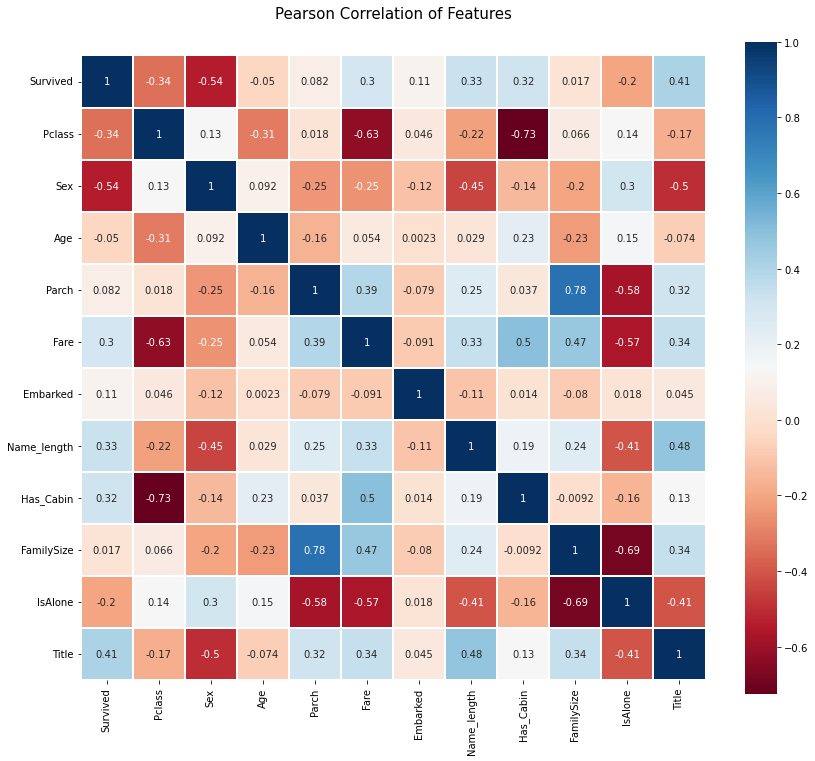

In [36]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white',annot=True)

### Takeaway from the plots
Pearson Correlation plot이 말해 줄 수 있는 한 가지는 서로 강한 상관 관계가 있는 feature가 너무 많지 않다는 것이다. 이는 train set에 중복되거나 불필요한 데이터가 많지 않고 각 feature가 고유한 정보를 전달한다는 것을 의미하기 때문에 이러한 feature를 train model에 제공하는 관점에서 좋다. 가장 관련성이 높은 두 가지 feature는 FamilySize와 Parch(부모 및 자녀)이다. 이 연습의 목적을 위해 여전히 두 feature를 모두 그대로 두자.  

### Pairplots
마지막으로 한 feature에서 다른 feature로의 데이터 분포를 관찰하기 위해 몇 가지 pairplot을 생성해 보자.

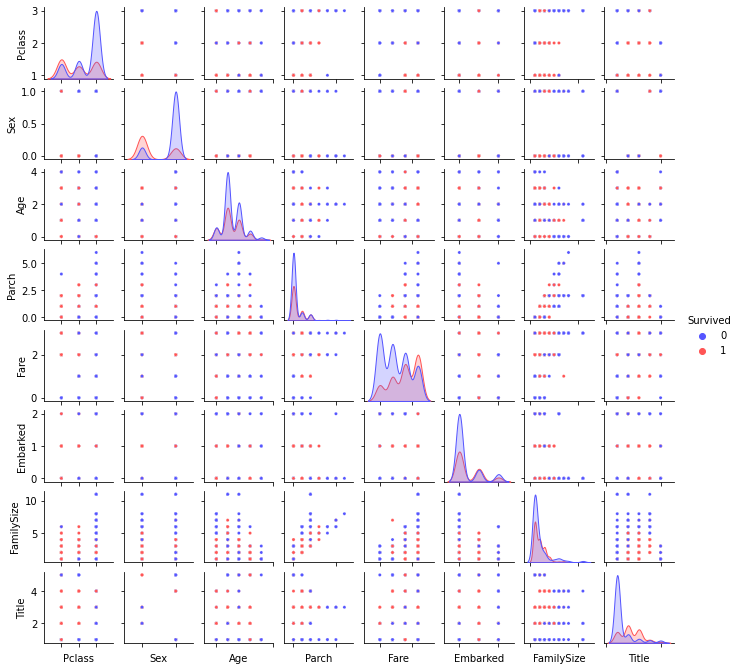

In [37]:
g = sns.pairplot(train[[u'Survived',u'Pclass',u'Sex',u'Age',u'Parch',u'Fare',u'Embarked',u'FamilySize',u'Title']], hue='Survived', palette='seismic',size=1.2, diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models
아래 코드 섹션에서 기본적으로 모든 Sklearn 분류기에 공통된 내장 메서드(예: train, predict 및 fit)를 확장할 수 있는 SklearnHelper 클래스를 작성한다. 따라서 5개의 다른 분류자를 호출하려는 경우 동일한 메서드를 5번 작성할 필요가 없으므로 중복성이 제거된다.

In [38]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

**def init** : 클래스의 기본 생성자를 호출하기 위한 Python 표준. 즉, 객체(분류자)를 생성하려면 clf(원하는 sklearn 분류자), seed(랜덤 시드) 및 params(분류자에 대한 매개변수)의 매개변수를 제공.  

나머지 코드는 단순히 sklearn 분류자 내에 이미 존재하는 해당 메서드를 호출하는 클래스의 메서드이다. 본질적으로 다양한 Sklearn 분류자를 확장하기 위해 래퍼 클래스를 생성하여 스태커에 여러 학습자를 구현할 때 동일한 코드를 반복해서 작성해야 하는 수고를 줄이는 데 도움이 된다.

### Out-of-Fold Predictions
이제 소개 섹션에서 위에서 언급한 것처럼 스태킹은 기본 분류기의 예측을 두 번째 level 모델에 대한 train을 위한 입력으로 사용한다. 그러나 단순히 전체 train 데이터에서 기본 모델을 train하고 전체 test 세트에서 예측을 생성한 다음 두 번째 level train을 위해 이를 출력할 수는 없다. 이렇게 하면 기본 모델 예측이 이미 test 세트를 "확인"하여 이러한 예측을 제공할 때 과적합될 위험이 있다.

In [39]:
def get_oof(clf, x_train, y_train, x_test, nfolds=5):
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.zeros((nfolds, x_test.shape[0]))

    kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)
    
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_val = x_train[val_index]

        clf.fit(x_tr, y_tr)

        oof_train[val_index] = clf.predict(x_val)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine  

### Parameters
**n_jobs** : training set에 사용되는 코어 수입. -1로 설정하면 모든 코어가 사용.  
**n_estimators** : train model의 분류 트리 수(default 10)  
**max_depth** : 트리의 최대 깊이 또는 노드를 확장해야 하는 정도다. 너무 높게 설정하면 트리가 너무 깊게 자랄 수 있으므로 과적합의 위험이 있으므로 주의해야한다.  
**verbose** : learning process 중에 텍스트를 출력할지 여부를 제어. 0 값은 모든 텍스트를 억제하고 3 값은 모든 반복에서 트리 학습 프로세스를 출력.

In [40]:
# Put in our parameters for said classifiers 
# Random Forest parameters
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    # 'max_features' : 0.2,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose' : 0
}

# Extra Trees parameters
et_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    # 'max_features' : 0.5,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators' : 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators' : 500,
    # 'max_features' : 0.2,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}


In [41]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating Numpy arrays out of our train and test sets
첫 번째 레이어 기본 모델을 준비했으므로 이제 다음과 같이 원래 데이터 프레임에서 NumPy 배열을 생성하여 분류자에 입력할 교육 및 테스트 테스트 데이터를 준비할 수 있다.

In [42]:
# Create Numpy arrays of train, test and target(Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'],axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test data

### Output of the First level Predictions
이제 train 및 test 데이터를 5개의 기본 분류기에 공급하고 이전에 정의한 Out-of-Fold 예측 기능을 사용하여 첫 번째 수준 예측을 생성한다. 

In [43]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers
이제 first level 분류자를 배웠으므로 Sklearn 모델의 매우 멋진 기능을 활용할 수 있다. 즉, 한 줄의 매우 간단한 코드로 교육 및 테스트 세트의 다양한 기능의 중요성을 출력할 수 있다.  

Sklearn 문서에 따르면 대부분의 분류자는 단순히 **.featureimportances**를 입력하여 기능 중요도를 반환하는 속성으로 내장되어 있다. 따라서 함수 earlylian을 통해 이 매우 유용한 속성을 호출하고 기능 중요도를 플롯한다.

In [44]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.10285265 0.21268732 0.03100774 0.02001865 0.04815167 0.0292774
 0.12985826 0.04933784 0.07235085 0.01148535 0.29297226]
[0.12088097 0.37897809 0.02758741 0.01639325 0.05586434 0.02862754
 0.04624893 0.08264386 0.04546225 0.0214088  0.17590457]
[0.03  0.01  0.022 0.064 0.036 0.01  0.692 0.012 0.052 0.002 0.07 ]
[0.08809312 0.01172699 0.0518843  0.01229826 0.05120774 0.02375321
 0.17189007 0.03760516 0.11124067 0.00685786 0.43344264]


In [45]:
rf_features = [0.10285265, 0.21268732, 0.03100774, 0.02001865, 0.04815167, 0.0292774, 0.12985826, 0.04933784, 0.07235085, 0.01148535, 0.29297226]
et_features = [0.12088097, 0.37897809, 0.02758741, 0.01639325, 0.05586434, 0.02862754, 0.04624893, 0.08264386, 0.04546225 ,0.0214088 , 0.17590457]
ada_features = [0.03,  0.01 , 0.022 ,0.064 ,0.036 ,0.01,  0.692, 0.012, 0.052, 0.002, 0.07 ]
gb_features = [0.08809312, 0.01172699, 0.0518843,  0.01229826, 0.05120774, 0.02375321, 0.17189007, 0.03760516, 0.11124067, 0.00685786, 0.43344264]

In [46]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### Interactive feature importances via Plotly scatterplots
이 시점에서 대화형 Plotly 패키지를 사용하여 다음과 같이 "Scatter"를 호출하여 플롯 산점도를 통해 다양한 분류자의 기능 중요도 값을 시각화한다.

In [47]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [48]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis=1) # axis=1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.102853,0.120881,0.030,0.088093,0.085457
1,Sex,0.212687,0.378978,0.010,0.011727,0.153348
2,Age,0.031008,0.027587,0.022,0.051884,0.033120


### Plotly Barplot of Average Feature Importances

In [49]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x = x,
    y = y,
    width = 0.5,
    marker = dict(
    color = feature_dataframe['mean'].values,
    colorscale = 'Portland',
    showscale = True,
    reversescale = False),
    opacity = 0.6
)]
layout = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance',
    hovermode = 'closest',
#    xaxis = dict(
#        title = 'Pop',
#        ticklen = 5,
#        zeroline = False,
#        gridwidth = 2,
#    ),
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2),
    showlegend = False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-levle Output
### First-level output as new features
First-level 예측을 얻었으므로 본질적으로 다음 분류기의 train 데이터로 사용할 새로운 feature 세트를 구축하는 것으로 생각할 수 있다. 따라서 아래 코드에 따라 이전 분류기의 First-level 예측을 새 열로 가지며 이에 대해 다음 분류기를 train한다.

In [50]:
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                      'ExtraTrees':et_oof_train.ravel(),
                                      'AdaBoost':ada_oof_train.ravel(),
                                      'GradientBoost':gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [52]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [53]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train),axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test),axis=1)

이제 First-Level의 train 및 test 예측을 x_train 및 x_test로 연결하고 조인했으므로 Second-Level의 학습 모델을 맞출 수 있다.

### Second level learning model via XGBoost
XGBoost는 대규모 부스트 트리 알고리즘을 최적화하기 위해 제작되었다.  
XGBClassifier를 호출하고 이를 First-Level train 및 target data에 fitting하고 학습된 모델을 사용하여 다음과 같이 test 데이터를 예측한다.

In [55]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    # gamma = 1,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

**gamma** : 트리의 리프 노드에서 추가 분할을 만드는 데 필요한 최소 손실 감소. 클수록 알고리즘이 더 보수적.  
**eta** : 과적합을 방지하기 위해 각 부스팅 단계에서 사용되는 단계 크기 축소

### Producing the Submission file
마지막으로 모든 First-level 및 Second-level 모델을 훈련하고 적합하게 만들었으므로 이제 다음과 같이 타이타닉 경쟁에 제출할 수 있는 적절한 형식으로 예측을 출력할 수 있다.

In [56]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

### Steps for Further Improvement
마지막으로 위에서 수행한 단계는 앙상블 스태커를 생성하는 매우 간단한 방법을 보여준다는 점에 유의해야 한다. 쌓인 분류기의 엄청난 조합과 2개 이상의 수준으로 가는 쌓임 수준을 포함하는 가장 높은 수준의 Kaggle 대회에서 생성된 앙상블에 대해 들었다.  

점수를 향상시키기 위해 취할 수 있는 몇 가지 추가 단계는 다음과 같다.  

1. 최적의 매개변수 값을 찾기 위해 모델을 교육할 때 우수한 교차 검증 전략 구현
2. 학습을 위한 더 다양한 기본 모델을 도입. 상관관계가 없는 결과일수록 최종 점수가 더 좋다.